In [238]:
from sqlalchemy import create_engine
from operator import itemgetter
import json
import math
import time
import random

import pandas as pd
import numpy as np
#import seaborn as sns
from sklearn import linear_model
from skopt import gp_minimize
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=6, suppress=True)
pd.options.mode.chained_assignment = None

In [163]:
race_type = 'R'
# race_type = 'G'
# race_type = 'H'

bet_type = 'W'
# bet_type = 'P'

pred = '{}_pred'.format(bet_type)
prob = '{}_prob'.format(bet_type)
bet = '{}_bet'.format(bet_type)

In [164]:
engine = create_engine('sqlite:///../../data/race.db')
conn = engine.connect()

dfoo = pd.read_sql_table('race', conn)
print('{} races loaded!'.format(len(dfoo)))

41694 races loaded!


In [165]:
dfo = dfoo.loc[dfoo['race_type'].isin([race_type])]
print('{} {} races for {} betting!'.format(len(dfo), race_type, bet_type))

13545 R races for W betting!


In [166]:
dfo.sort_values('race_start_time', inplace=True)
print(dfo['race_start_time'][0])

2017-10-01 01:40:00


In [167]:
dfo['results'] = dfo['results_data'].map(json.loads)
dfo['runners'] = dfo['runners_data'].map(json.loads)
dfo.tail(3)

,id,meeting_name,location,venue_mnemonic,race_type,meeting_date,race_number,race_name,race_start_time,race_status,race_distance,results_data,num_runners,runners_data,quinella,exacta,trifecta,first_four,results,runners
39079,51484,MUSSELBURGH,GBR,T,R,2017-10-16,8,RACING UK NOW IN HD AMATEUR RIDERS,2017-10-16 16:25:00,Paying,3217,"[[7], [8], [1], []]",NaN,"[{""runnerName"": ""CHEBSEY BEAU"", ""runnerNumber""...",16.6,24.8,75.5,NaN,"[[7], [8], [1], []]","[{'runnerName': 'CHEBSEY BEAU', 'runnerNumber'..."
39106,51511,WINDSOR,GBR,E,R,2017-10-16,8,MPM FLOORING LTD MAIDEN STAKES,2017-10-16 16:30:00,Paying,1631,"[[8], [3], [5], []]",NaN,"[{""runnerName"": ""BINGO GEORGE"", ""runnerNumber""...",7.2,9.6,20.1,NaN,"[[8], [3], [5], []]","[{'runnerName': 'BINGO GEORGE', 'runnerNumber'..."
39011,51412,GREAT YARMOUTH,GBR,L,R,2017-10-16,9,RACING WELFARE HANDICAP,2017-10-16 16:40:00,Paying,1603,"[[2], [5], [1], []]",NaN,"[{""runnerName"": ""ZESHOV"", ""runnerNumber"": 1, ""...",15.2,44.0,61.4,NaN,"[[2], [5], [1], []]","[{'runnerName': 'ZESHOV', 'runnerNumber': 1, '..."


In [239]:
def process_strategy(dfp, x, cutoff=1):
    """run strategy, must pass runners returned back into results (it might be modified)"""
    book = []
    for _, race in dfp.iterrows():
        # cutoff
        if random.random() > cutoff:
            continue

#         print(race['num_runners'])
        runners = race['runners']
        
        # drop scratched
        runners = [r for r in runners if r.get('has_odds')]
        if len(runners) < 2:
            continue

        try:
            runners, num_bets = bet_dutch(runners, 1, race_type, bet_type, x)
        except Exception as e:
            print(runners)
            raise
            
        if num_bets:
            bet_results(book, runners, num_bets)
        
#         raise Exception('ps')
            
    book_df = pd.DataFrame(book)
    return book_df

In [264]:
def bet_results(book, runners, num_bets):
    """get results from bets"""
    prob = '{}_prob'.format(bet_type)
    bet = '{}_bet'.format(bet_type)
    place_cutoff = 3 if len(runners) >= 8 else 2

    # profit start with loss of bet made
    outcome = {
        'success': 0,
        'profit': -sum([r[bet] for r in runners]),
        'num_bets': num_bets,
        'num_runners': len(runners),
        'bet_chunk': sum([r[bet] for r in runners]),
        'bets_on_newbies': sum(r['cnt'] == 1 for r in runners if r[bet]),
        'newbies_in_race': sum(r['cnt'] == 1 for r in runners),
    }

    for i, runner in enumerate(runners):
        if runner[bet]:
            if bet_type == 'W':
                if int(runner['finishingPosition']) == 1:
                    outcome['success'] = 1
                    # profit will be payout added against inital deduction
                    # winnings is the bet made times the odds
                    winnings = runner[bet] * runner['win_odds']
                    outcome['profit'] += winnings
                break
            elif bet_type == 'P':
                if 1 <= int(runner['finishingPosition']) <= place_cutoff:
                    # success is how correct each placement was
                    outcome['success'] += 1 / num_bets
                    # profit will be return added and offset against inital deduction
                    # winnings is the bet made times the odds
                    winnings = runner[bet] * runner['place_odds']
                    outcome['profit'] += winnings
    
    book.append(outcome)

In [265]:
def bet_dutch(runners, bet_chunk, race_type, bet_type, x=None):
    """dutch betting on probability"""
    prob = '{}_prob'.format(bet_type)
    bet = '{}_bet'.format(bet_type)
#     print('X = {}'.format(x))

    # sort runners from favourite to underdog
    runners.sort(key=lambda r: r.get(prob, 0), reverse=True)
    
    # start betting on all and cut off worse runner till positive outcome
    for num_bets in range(len(runners), 0, -1):

        # reset bets
        for runner in runners:
            runner[bet] = 0
            runner['{}_type'.format(bet)] = 'parimutuel'
            runner['payout'] = 0

        # recreate smaller pool
        pool = runners[:num_bets]
#         print('pool is {} from {} bets'.format(len(pool), num_bets))

        # dutch for all in pool
        for runner in pool:
            # skip negative probability
            if runner[prob] <= 0:
#                 print('#{} has negative prob {:.2f}'.format(runner['runnerNumber'], runner[prob]))
                continue
                
            # scale bet according to probability
            bet_amt = round(runner[prob] * bet_chunk)
            runner[bet] = bet_amt
#             print('#{} bet={:.2f}'.format(runner['runnerNumber'], runner[bet]))
            if not runner[bet]:
                continue

            # payouts
            # need to check all as we scale to probs and not odds
            if bet_type == 'W':
                odds = runner['win_odds']
            elif bet_type == 'P':
                odds = runner['place_odds']
#             print('odds {:.2f} and scaled {:.2f}'.format(odds, scaled))
            runner['payout'] = runner[bet] * odds

        ###################################################################################
        # BETS ON NEWBIES
        ###################################################################################
        bets_on_newbies_flag = False
        newbies = sum(p['cnt'] == 1 for p in pool if p[bet])
        if newbies / len(runners) <= x[0]:
            bets_on_newbies_flag = True

        ###################################################################################
        # NEWBIES IN RACE
        ###################################################################################
        newbies_in_race_flag = False
        newbies = sum(r['cnt'] == 1 for r in runners)
        if newbies / len(runners) <= x[1]:
            newbies_in_race_flag = True

        ###################################################################################
        # MIN PROFIT
        ###################################################################################
        min_profit_flag = False
        total_bets = sum(p[bet] for p in pool)
        profits = [p['payout'] - total_bets for p in pool]
        if min(profits) >= x[2]:
            min_profit_flag = True
        
        if bets_on_newbies_flag and newbies_in_race_flag and min_profit_flag:
#             print('breaking!')
#             raise Exception('foo')
            break
#         else:
#             print('flag not hit')
    else:
#         print('no profit determined')
        return [], 0

    # put bets from pool into runners
    for p in pool:
        for r in runners:
            if r['runnerNumber'] == p['runnerNumber']:
                r[bet] = p[bet]
                r['{}_type'.format(bet)] = p['{}_type'.format(bet)]
                break

    return runners, num_bets

In [275]:
def f(x):
    print('.', end='')
    cutoff = 1 / len(dfo)
    book_df = process_strategy(dfo, x, cutoff)
#     print(book_df)
#     raise Exception('f')
    if not len(book_df):
        return 0
    profit = book_df.profit.sum()
    return profit / len(dfo) * -1
    

print('optimizing', end='')
time_start = time.time()

x, *grid = sp.optimize.brute(f, np.s_[0:1:10j, 0:1:10j, 0:20:10j], full_output=True)

print('done: took {:.0f}s'.format((time.time() - time_start)), flush=True)
# print('x: {}'.format(x))
# print('grid: {}'.format(grid))

optimizing..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [276]:
print('category: {}'.format(race_type))
print('bet type: {}'.format(bet_type))
print('x: {}'.format(x))
df = process_strategy(dfo, x)
print('${:.2f} profit per race'.format(df.profit.sum() / len(dfo)))
print('{:.0f}% of races {} / {}'.format(len(df) / len(dfo) * 100, len(df), len(dfo)))

category: R
bet type: W
x: [ 0.  0.  0.]
$-0.01 profit per race
15% of races 2000 / 13545


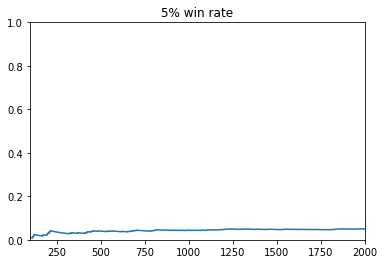

In [277]:
df['ones'] = np.ones(len(df))
df['win_rate'] = df.success.cumsum() / df.ones.cumsum()
win_title = '{:.0f}% win rate'.format(df.win_rate.iloc[-1] * 100)
df.win_rate.plot(title=win_title, xlim=(100), ylim=(0, 1))

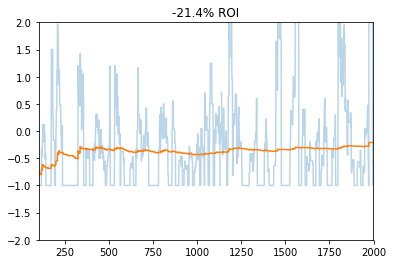

In [278]:
# ROI
roi = df.profit.rolling(20).sum() / df.bet_chunk.rolling(20).sum()
roi.plot(xlim=(100), ylim=(-1, 1), alpha=0.3)
roi = df.profit.cumsum() / df.bet_chunk.cumsum()
roi_title = '{:.1f}% ROI'.format(roi.iloc[-1] * 100)
roi.plot(xlim=(100), ylim=(-2, 2), title=roi_title)

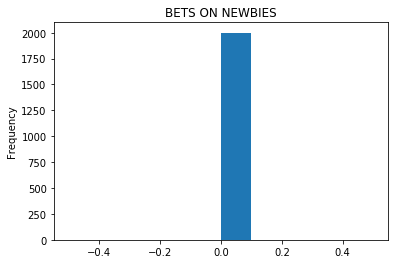

In [279]:
# BETS ON NEWBIES
df.bets_on_newbies.plot(kind='hist', title='BETS ON NEWBIES')
# groups = df.groupby('num_bets').mean()
# groups.plot(kind='bar', y='success', title='Win rate per #bets')
# groups.plot(kind='bar', y='profit', title='Profit per #bets')

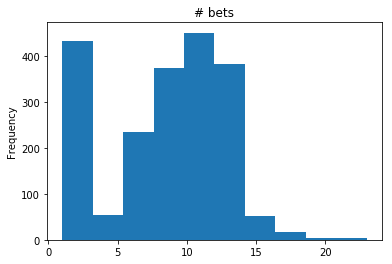

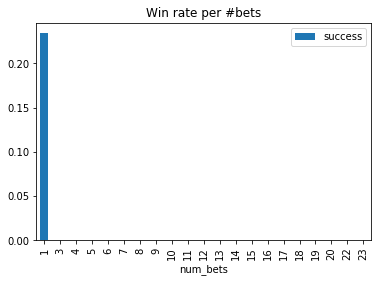

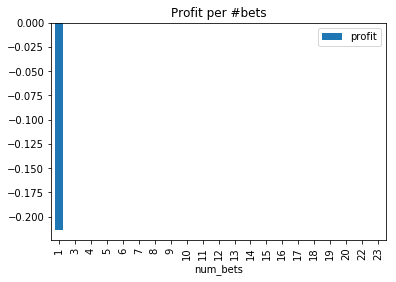

In [280]:
# profit per num bets 
df.num_bets.plot(kind='hist', title='# bets')
groups = df.groupby('num_bets').mean()
groups.plot(kind='bar', y='success', title='Win rate per #bets')
groups.plot(kind='bar', y='profit', title='Profit per #bets')

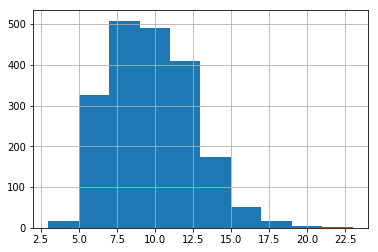

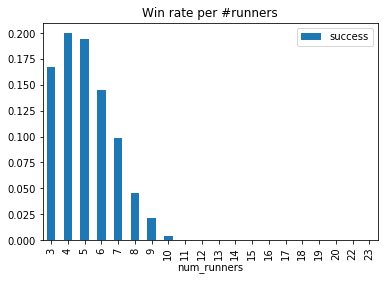

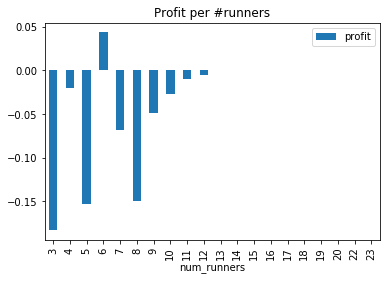

In [281]:
# profit per num runners
df.num_runners.hist()
groups = df.groupby('num_runners').mean()
groups.plot(kind='bar', y='success', title='Win rate per #runners')
groups.plot(kind='bar', y='profit', title='Profit per #runners')

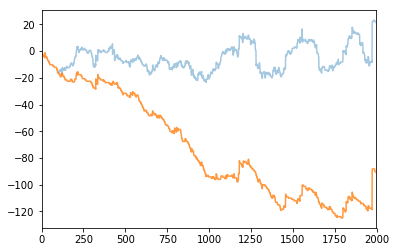

In [282]:
# df.profit.plot(kind='hist', bins=50, xlim=(-5), ylim=(0, 140))
df.profit.rolling(100).sum().plot(alpha=0.4)
df.profit.cumsum().plot(alpha=0.8)

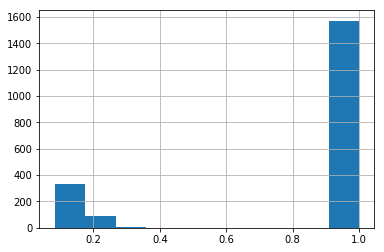

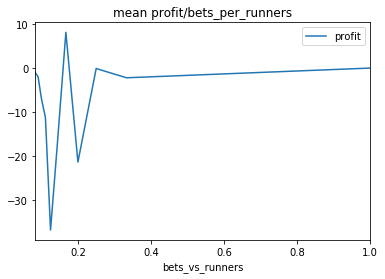

In [283]:
# bets/runners
df['bets_vs_runners'] = df.num_bets / df.num_runners
df['bets_vs_runners'].hist(bins=10)
groups = df.groupby(df['bets_vs_runners'].apply(lambda x: round(x, 3))).sum()
groups.plot(kind='line', y='profit', title='mean profit/bets_per_runners')